# **Обратный маятник**

---



![Схема маятника](https://deustotech.github.io/DyCon-Blog/assets/imgs/DP00/P0003/Pendulum_pic.png)

Рассматривается проблема стабилизации обратного маятника. Движение маятника происходит в плоскости XoZ. Невесомый стержень закреплён на тележке, которая может перемещаться под действием горизонтально приложенной силы u(так называемый x inverted pendulum).

Пусть m, M - массы грузика и тележки соответственно. l - расстояние от точки крепления до грузика. Кинетическая и потенциальная энергия системы имеют вид
$$K = \frac{1}{2} M \dot x^2 + \frac{1}{2} m (\dot x_{p}^2 + \dot z_{p}^2)$$
$$П = mgz_{p}$$
где $x_{p} = x + l \sin{\theta}$, $z_{p} = x + l \cos{\theta}$, g - ускорение свободного падения

Из уравнений Лагранжа следует система
\begin{equation*}
 \begin{cases}
   (M + m) \ddot x + m l \ddot \theta \cos{\theta} - m l \dot \theta^2 \sin{\theta} = u\\
   \ddot x \cos{\theta} + l \ddot \theta - g sin{\theta} = 0
 \end{cases}
\end{equation*}
Приводя к нормальной форме Коши, получим
\begin{equation}
 \begin{cases}
   \dot x_{0} = x_{1}\\
   \dot x_{1} = \frac{- m g \cos{x_{2}} \sin{x_{2}} + m l x_{3}^2 \sin{x_{2}} + u}{M + m \sin^2{x_{2}}} + d_{1}\\
   \dot x_{2} = x_{3}\\
   \dot x_{3} = \frac{m l x_{3}^2 \cos{x_{2}} \sin{x_{2}} - u \cos{x_{2}} + (M + m) g \sin{x_{2}} }{M l + m l \sin^2{x_{2}}} + d_{2}
 \end{cases}
\end{equation}
где $d_{1}$ и $d_{2}$ - сторонние возмущения, которые могут действовать на систему

# Стабилизация угла

Для выполения задачи достаточно одного ПИД-регулятора. 

In [84]:
from math import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Параметры маятника

In [85]:
class Parameters:

    def __init__(self):
        self.m = 0.1
        self.M = 1.
        self.l = 0.3
        self.g = 9.8

Right hand system - правая часть системы дифференциальных уравнений

In [86]:
def rhs(t, x, p, u):
    dxdt = np.zeros(4)
    dxdt[0] = x[1]
    dxdt[1] = (-p.m * p.g * cos(x[2]) * sin(x[2]) + p.m * p.l * sin(x[2]) * x[3] ** 2 + u) / (
            p.M + p.m * sin(x[2]) ** 2)
    dxdt[2] = x[3]
    dxdt[3] = (-p.m * p.l * cos(x[2]) * sin(x[2]) * x[3] ** 2 - cos(x[2]) * u + (p.M + p.m) * p.g * sin(x[2])) / (
            p.M * p.l + p.m * p.l * sin(x[2]) ** 2)
    return dxdt

Управляющее устройство(ПИД - регулятор)

In [87]:
class PID_Controller():
    def __init__(self, dt, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.integral = 0
        self.dt = dt
        self.e_prev = None

    def update(self, state, reference):
        error = state - reference
        if self.e_prev is None:
            dedt = 0
        else:
            # Производная ошибки считается простейшей формулой первого порядка аппроксимации
            dedt = (error - self.e_prev) / self.dt
        # Интеграл считается простейшей формулой прямоугольников
        self.integral = self.integral + error * self.dt

        self.e_prev = error
        return self.kp * error + self.ki * self.integral + self.kd * dedt

Требуемое значение угла, в котором должен удерживаться маятник

In [88]:
def reference_angle(t):
    return 0

Непосредственно решатель системы уравнений 

In [89]:
def solve(t0, tf, dt, x0, p, pid):
    time = np.arange(t0, tf, dt)
    result = x0
    force = []
    for i in range(len(time) - 1):
        u = pid.update(x0[2], reference_angle(time[i]))
        force = np.append(force, u)
        solution = solve_ivp(lambda t, x: rhs(t, x, p, u), (time[i], time[i + 1]), x0)
        x0 = solution.y[:, -1]
        result = np.vstack((result, x0))
    return time, force, result

Параметры регулятора и интегратора, графики решений. 

Если в начальный момент времени маятник отклонён на 0.5 радиан, то он быстро приходит в верхнее положение и остается там при $k_{p} = 25$, $k_{i} = 15$, $k_{d} = 3$

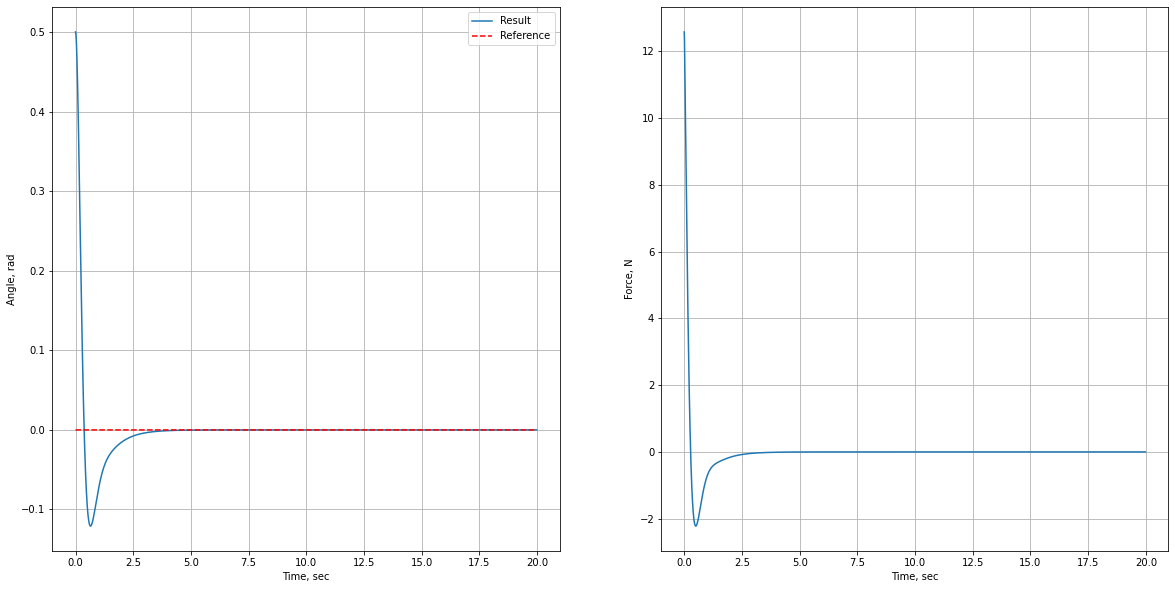

In [90]:
t_0 = 0
t_f = 20
d_t = 0.01
init = [0., 0., 0.5, 0.]
param = Parameters()
pid = PID_Controller(d_t, 25, 15, 3)
[t, f, x] = solve(t_0, t_f, d_t, init, param, pid)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, x[:, 2], label = 'Result')
ax.plot(t,np.zeros_like(x[:, 2]),'--',color ='r', label = 'Reference')
ax.grid()
ax.legend()
ax.set_xlabel('Time, sec')
ax.set_ylabel('Angle, rad')
ax = fig.add_subplot(1, 2, 2)
ax.plot(t[0:-1], f)
ax.set_xlabel('Time, sec')
ax.set_ylabel('Force, N')
ax.grid()
plt.show()

#Стабилизация угла и положения тележки

![Пид-регуляторы](https://ars.els-cdn.com/content/image/1-s2.0-S1569190X10001796-gr2.jpg)

Добвим второй ПИД-регулятор, который позволит контролировать положение тележки, то есть точки крепления стержня. 

Пусть теперь тележка стоит на коротком столе, а потому её движение ограничено:  $-0.5 \leq x \geq 0.5$. Учтём это простейшим образом, не допуская длительного воздействия, выводящего систему за данные рамки

In [91]:
def reference_position(t):
    return 0
def rhs(t, x, p, u):
    dxdt = np.zeros(4)
    dxdt[0] = x[1]
    dxdt[1] = (-p.m * p.g * cos(x[2]) * sin(x[2]) + p.m * p.l * sin(x[2]) * x[3] ** 2 + u) / (
            p.M + p.m * sin(x[2]) ** 2)
    dxdt[2] = x[3]
    dxdt[3] = (-p.m * p.l * cos(x[2]) * sin(x[2]) * x[3] ** 2 - cos(x[2]) * u + (p.M + p.m) * p.g * sin(x[2])) / (
            p.M * p.l + p.m * p.l * sin(x[2]) ** 2)
    return dxdt
def solve(t0, tf, dt, x0, p, pid1, pid2):
    time = np.arange(t0, tf, dt)
    result = x0
    force = []
    for i in range(len(time) - 1):
        u = pid1.update(x0[2], reference_angle(time[i])) - pid2.update(x0[0], reference_position(time[i]))
        force = np.append(force, u)
        solution = solve_ivp(lambda t, x: rhs(t, x, p, u), (time[i], time[i + 1]), x0)
        x0 = solution.y[:, -1]
        if abs(x0[0]) > 0.5:
            x0[0] = 0.5 * np.sign(x0[0])
            i = i - 1
        result = np.vstack((result, x0))
    return time, force, result

Если в нулевой момент времени маятник отклонён на 0.5 радиан, а тележка находится в начале координат и неподвижна, то при тех же параметрах регулятора угла и при параметрах $k_{p} = -2.4$, $k_{i} = -1$, $k_{d} = -0.75$ регулятора положения тележки система быстро приходит в требуемое состояние $x = 0 $, $\theta = 0$

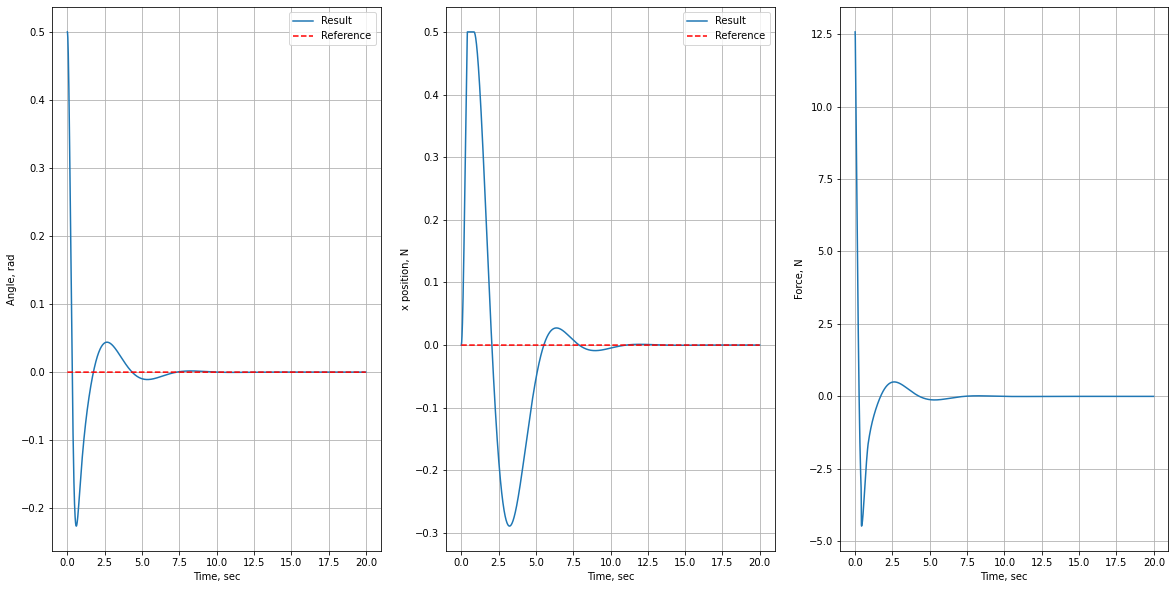

In [92]:
t_0 = 0
t_f = 20
d_t = 0.01
init = [0., 0., 0.5, 0.]
param = Parameters()
pid1 = PID_Controller(d_t, 25, 15, 3)
pid2 = PID_Controller(d_t, -2.4, -1, -0.75)
[t, f, x] = solve(t_0, t_f, d_t, init, param, pid1, pid2)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 3, 1)
ax.plot(t, x[:, 2], label = 'Result')
ax.plot(t,np.zeros_like(x[:, 2]),'--',color ='r', label = 'Reference')
ax.grid()
ax.legend()
ax.set_xlabel('Time, sec')
ax.set_ylabel('Angle, rad')
ax = fig.add_subplot(1, 3, 2)
ax.plot(t, x[:, 0], label = 'Result')
ax.plot(t,np.zeros_like(x[:, 0]),'--',color ='r', label = 'Reference')
ax.set_xlabel('Time, sec')
ax.set_ylabel('x position, N')
ax.grid()
ax.legend()
ax = fig.add_subplot(1, 3, 3)
ax.plot(t[0:-1], f)
ax.set_xlabel('Time, sec')
ax.set_ylabel('Force, N')
ax.grid()
plt.show()

# Выход на заданную тректорию 

С помощью двух воздействий можно также заставлять маятник двигаться по желаемой траектории. Пусть мы хотим добиться периодического движения вида $x = 0.3 \sin{0.05 \pi t}$, а на систему дополнительно влияют сильные сторонние возмущения $d_{1} = d_{2}= 20 \sin{20 \pi t}$. Не изменяя параметры регуляторов, можно быстро получить необходимое движение.

In [93]:
def reference_position(t):
    return 0.3 * sin(0.05 * pi * t)
def rhs(t, x, p, u):
    dxdt = np.zeros(4)
    dxdt[0] = x[1]
    dxdt[1] = (-p.m * p.g * cos(x[2]) * sin(x[2]) + p.m * p.l * sin(x[2]) * x[3] ** 2 + u) / (
            p.M + p.m * sin(x[2]) ** 2) + 20 * sin(20 * pi * t)
    dxdt[2] = x[3]
    dxdt[3] = (-p.m * p.l * cos(x[2]) * sin(x[2]) * x[3] ** 2 - cos(x[2]) * u + (p.M + p.m) * p.g * sin(x[2])) / (
            p.M * p.l + p.m * p.l * sin(x[2]) ** 2) + 20 * sin(20 * pi * t)
    return dxdt

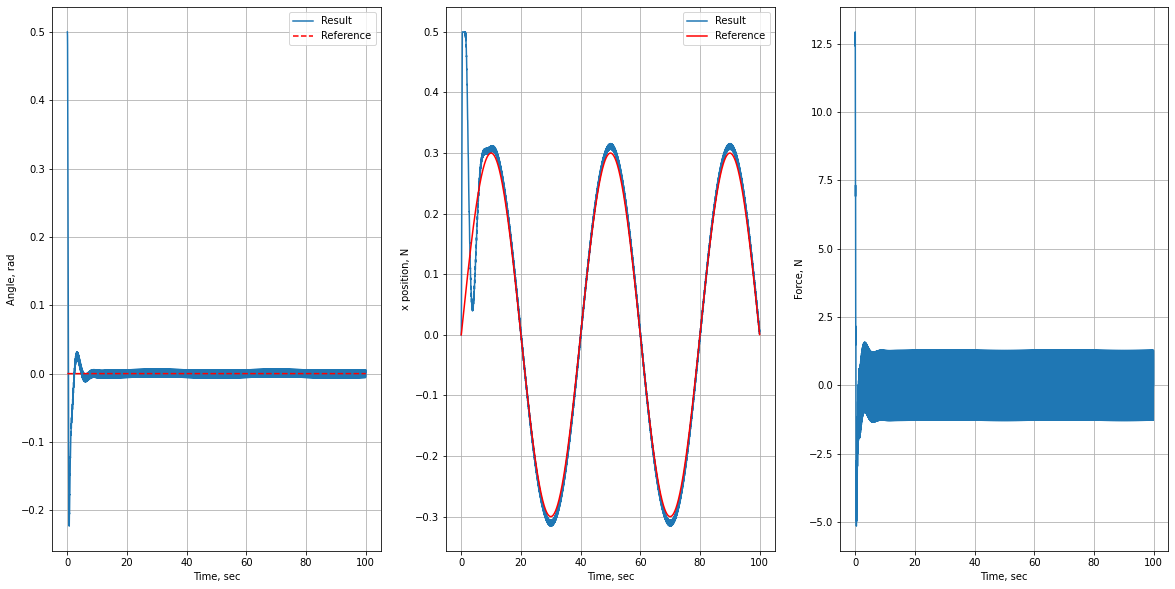

In [94]:
t_0 = 0
t_f = 100
d_t = 0.01
init = [0., 0., 0.5, 0.]
param = Parameters()
pid1 = PID_Controller(d_t, 25, 15, 3)
pid2 = PID_Controller(d_t, -2.4, -1, -0.75)
[t, f, x] = solve(t_0, t_f, d_t, init, param, pid1, pid2)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 3, 1)
ax.plot(t, x[:, 2], label = 'Result')
ax.plot(t,np.zeros_like(x[:, 2]),'--',color ='r', label = 'Reference')
ax.grid()
ax.legend()
ax.set_xlabel('Time, sec')
ax.set_ylabel('Angle, rad')
ax = fig.add_subplot(1, 3, 2)
ax.plot(t, x[:, 0], label = 'Result')
ax.plot(t, [reference_position(t[i]) for i in range(len(t))], color = 'r', label ='Reference')
ax.legend()
ax.set_xlabel('Time, sec')
ax.set_ylabel('x position, N')
ax.grid()
ax = fig.add_subplot(1, 3, 3)
ax.plot(t[0:-1], f)
ax.set_xlabel('Time, sec')
ax.set_ylabel('Force, N')
ax.grid()
plt.show()

# Выводы

Таким образом, грамотная конструкция системы управления с использованием обыкновенных ПИД-регуляторов способна контролировать поведение обратного маятника: не только удерживать систему в заданном положении, но и устанавливать предложенную траекторию. Однако, главная проблема заключается в тонкости подбора параметров регуляторов, который фактически происходит методом проб и ошибок 